### Import Library

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

### Import data

앞서 2장때 이미지를 불러오는 방법을 배웠습니다.

이를 이용하여 tensorflow를 이용하여 딥러닝에 학습을 시킬 수 있는 형태로 바꾸어주도록 하겠습니다.

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True,
                                   )
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


batch size를 크게 가져가면 한 번의 step에서 loss의 편차가 더 작아지므로 좀 더 일반화시킬 수 있습니다.

반면 batch size를 작게 가져가면 step마다 loss의 편차가 크기 때문에 더 민감하게 모델을 학습시킬 수 있습니다.

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(384, 384),
  batch_size=16)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(384, 384),
  batch_size=16)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


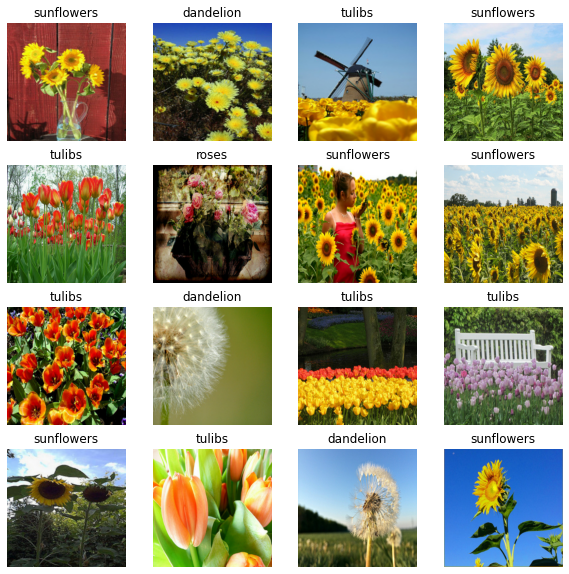

In [4]:
class_names = ['daisy','dandelion','roses','sunflowers','tulibs']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 모델 정의

이제 Convolution layer를 통해 모델을 직접 생성해보도록 하겠습니다.

현재 baseline code는 최소한의 동작할 수 있는 정도로만 구현을 하였습니다. 그렇기에 train과 valid/test 사이에 성능 차이가 매우 심할 것입니다.

여기에 여러분들이 어떻게 하면 성능을 향상시킬 수 있을 지, 공부해보고 모델을 비교해보면 되겠습니다.

고려할 점들

- 모델의 정도: 깊게 쌓을 것인가(Layer를 늘릴지), 혹은 넓게 쌓을 것인가(Filter를 늘릴지), kernal_size를 어떻게 조절할 것인지?
- Dropout: Overfitting을 어떻게 방지할 것인가?
- Batch Normalization: 배치 단위로 정규화를 넣어줄 것인지
- Activation function: 다른걸 써볼 수 있을지 (그러나 CNN의 국룰은 ReLU임)
- 그 외

**dropout**은 train 데이터에 대한 복잡한 상호작용을 방지해서 과적합을 줄일 수 있습니다.

또한 합리적인 시간 내에 네트워크들을 학습할 수 있어서 컴퓨팅 자원을 절약할 수도 있습니다!


**배치 정규화**는 각 층에서의 활성화값이 적당히 분포되도록 입력을 정규화하는 것을 목표로 합니다. 

학습 속도를 개선하고 과적합을 억제하는 역할을 합니다.

이번 코드에서는 filter 수를 늘리고 레이어를 추가하여 학습력을 높이고 배치 정규화와 dropout 과정을 추가하여 train data의 과적합을 방지하였습니다.

또한 image size를 224x224에서 384x384로 변경하여 더욱 정확도를 높여 보았습니다!

In [5]:
def deep_cnn_advanced():
    model = Sequential()
    
    model.add(Conv2D(input_shape = (384, 384, 3), filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax'))
    
    learning_rate = 1e-4
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])
    
    return model    

Task에 맞는 적절한 loss와, 데이터에 맞는 optimizer를 선택하는 것도 학습에 영향을 줍니다.

- Loss: 어떤 loss를 사용할 것인가?
- Optim: SGD 외에 RMSprop, Adam 등으로 바꾸면 학습에 어떤 영향을 미치는가?
- Learning rate: 어느정도의 속도로 학습할 것인가?

In [6]:
### 모델 및 파라미터 할당
model = deep_cnn_advanced()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [8]:
### 모델 동작 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 384, 384, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 384, 384, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 384, 384, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 384, 384, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 384, 384, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 384, 384, 64)      0

### 모델 훈련

이제 모델과 학습 요소들을 모두 정의했다면, 데이터를 통해 모델을 훈련해보도록 하겠습니다.

In [ ]:
### 모델 훈련
with tf.device("/device:GPU:0"):
    hist = model.fit(train_ds, epochs=50, batch_size=32,
                    validation_data=val_ds)

Epoch 1/50
184/184 [==============================] - ETA: 0s - loss: 1.5967 - accuracy: 0.3300

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


184/184 [==============================] - 61s 328ms/step - loss: 1.5967 - accuracy: 0.3300 - val_loss: 1.4863 - val_accuracy: 0.4046
Epoch 2/50
184/184 [==============================] - 59s 316ms/step - loss: 1.3435 - accuracy: 0.4278 - val_loss: 1.2665 - val_accuracy: 0.4673
Epoch 3/50
184/184 [==============================] - 59s 316ms/step - loss: 1.2153 - accuracy: 0.4997 - val_loss: 1.1400 - val_accuracy: 0.5109
Epoch 4/50
184/184 [==============================] - 59s 317ms/step - loss: 1.1121 - accuracy: 0.5525 - val_loss: 1.0974 - val_accuracy: 0.5368
Epoch 5/50
184/184 [==============================] - 59s 317ms/step - loss: 1.0595 - accuracy: 0.5685 - val_loss: 1.0570 - val_accuracy: 0.5586
Epoch 6/50
184/184 [==============================] - 59s 317ms/step - loss: 0.9656 - accuracy: 0.6141 - val_loss: 1.0545 - val_accuracy: 0.5627
Epoch 7/50
184/184 [==============================] - 59s 317ms/step - loss: 0.9189 - accuracy: 0.6448 - val_loss: 1.0757 - val_accuracy: 0.5

### 모델 평가

모델이 학습을 모두 완료했다면, 새로운 데이터를 통해 얼마나 잘 맞추었는가를 평가해보겠습니다.

In [ ]:
### 평가
model.evaluate(val_ds)

In [ ]:
y_prob = model.predict(val_ds)

In [ ]:
### 예측
y_prob = model.predict(val_ds)
y_pred = np.argmax(y_prob, axis=1)
y_test = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
### 예측 리포트
from sklearn.metrics import classification_report, confusion_matrix
print('\n Classification report \n\n',
  classification_report(
      y_test,
      y_pred,
       target_names=class_names
      )
  )

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(hist.history['accuracy'],marker = 'o', ms = 2, label = "Train accuracy")
plt.plot(hist.history['val_accuracy'],marker = 'o', ms = 2, label = "Valid accuracy")
plt.title(f'Accuracy');
plt.ylabel('Acc');
plt.xlabel('epoch')
plt.legend(), plt.grid()

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(hist.history['loss'],marker = 'o', ms = 2, label = "Train loss")
plt.plot(hist.history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
plt.title(f'Loss');
plt.ylabel('Loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()